# Sampling algorithm 테스트.

1. Cartesian에서 sampling을 하는경우와 distance space에서 샘플링을 하는 경우를 다룸.
2. Time-reversal 샘플링 과정에서 $h$ 를 없애고 샘플링을 하는것을 고려중

---
Time reversal sampling은 $x_{t} = x_{t+1} - dx_{t}$ 꼴으로 진행된다.

$$dx_{t}=\left[f(x_t, t) - g^2(t)\left(s(x_t, t, x_0, x_T)-h(x_t , t, x_T) \right)\right]dt + g(t)dw_t$$

여기서 

$$ s^* = \nabla_{x_t} q(x_t \vert x_0, x_T) = 2 (\mu_t - x_t) / \hat{\sigma}^2_t$$

where, 
$$\mu_t = \frac{\sigma_t^2}{\sigma_T^2} x_T + (1-\frac{\sigma_t^2}{\sigma_T^2}) x_0$$

$$\hat{\sigma}^2_t=\sigma^2_t\left(1-\frac{\sigma_t^2}{\sigma_T^2}\right)$$



In practice,

$$d\sigma^2(t) /dt = \beta(t) = g^2(t)$$

$$\{\beta_{t}\}=\{\beta_0, \beta_1, \beta_2, ..., \beta_{T-1}\}$$

$$\sigma^2_t=\sum_{i=0}^{t-1}\beta_{i} + \sigma^2_0\quad \forall 1\le t \le T$$

그리고, 실질적으로 discrete하게 SDE를 푸는 과정에서 $h, f = 0$ 이라고 가정하고, wiener process없이 문제를 푼다면 

$$dx_t= -2 \frac{\beta_t}{\sigma^2_t(1-\sigma^2_t/\sigma^2_T)}(\mu_t - x_t)$$




---
문제점 : 

1. $t \to 0$ 경우 score값이 불안정해지면서, 에러가 약간 더 커지는 상황 발생
2. $t \to T$ 경우 score값이 **매우** 불안정해지면서, 구조가 완전히 망가져버리는 현상 발생

In [6]:
import numpy as np
import torch

from scipy.spatial.distance import cdist, pdist
import scipy

import os
import ase.io
import ase
import sys

from torch_scatter import scatter_add

from lst_interp import *

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def beta_scheduler(max_beta=1e-2, min_beta=1e-5):
    t = torch.linspace(0, 1, 100)
    betas = t * (max_beta - min_beta) 
    betas += min_beta - min(betas)
    return betas


def sigmoidal(x):
    return 1.0 / (1.0 + torch.exp(-x))
    

def get_beta_schedule(min_t, max_t, num_steps, min_beta, max_beta):
    # num_steps = T
    # sigmoidal schedule
    t = torch.linspace(min_t, max_t, num_steps)
    beta_t = sigmoidal(t) * (max_beta - min_beta) + min_beta
    # beta_t = t * (max_beta - min_beta) + min_beta
    return beta_t


def eq_transform(score_d, pos, edge_index, edge_length):
    N = pos.size(0)
    dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]]) * 0.5
    score_d = score_d.reshape(-1, 1)
    score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
    score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
    return score_pos


def pos_to_dist(pos):
    length = torch.Tensor(pdist(pos))
    index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
    return index, length


def pinned_score(x_t, t, betas, sigma_square, x_T):
    sigma_t_square = sigma_square[t]
    sigma_T_square = sigma_square[-1]
    beta_t = betas[t]

    # calc score
    diff = x_T - x_t
    coeff = beta_t * 2 / (sigma_T_square - sigma_t_square)
    score = diff * coeff
    return score


def pinned_score2(x_t, t, betas, sigma_square, x_T):
    # calculate parameters
    sigma_t_square = sigma_square[t]
    sigma_T_square = sigma_square[-1]
    beta_t = betas[t]

    # calc diff
    index, d_t = pos_to_dist(x_t)
    index, d_T = pos_to_dist(x_T)
    diff = d_T - d_t
    diff_pos = eq_transform(diff, x_t, index, d_t)

    # calc score
    coeff = beta_t * 2 / (sigma_T_square - sigma_t_square)
    score = diff_pos * coeff
    return score


def pinned_diffusion_proccess(x_t, t, betas, x_T, coord="Cartesian"):
    beta_t = betas[t]
    if coord == "Cartesian":
        dx = beta_t * pinned_score(x_t, t, betas, x_T) + torch.sqrt(beta_t) * torch.randn_like(x_t)
    else:
        dx = beta_t * pinned_score2(x_t, t, betas, x_T) + torch.sqrt(beta_t) * torch.randn_like(x_t)
    x_tp1 = x_t + dx
    return x_tp1


def diffusion_proccess(x_t, beta_t):
    dx = x_t + torch.sqrt(beta_t) * torch.randn_like(x_t)
    x_tp1 = x_t + dx
    return x_tp1


def diffusion_kernel(x0, t, beta_t):
    # t = 1, 2, 3, ... T
    x_t = x0 + torch.sqrt(beta_t[:t].sum()) * torch.randn_like(x0)
    return x_t


def reverse_diffusion_process(x_t, t, betas, x_0, x_T, coord="Cartesian", h_coeff=0.0, sigma_min=1e-3, sigma_last=1e-5):
    beta_t = betas[t]
    num_time_steps = len(betas)
    dt = (1 / num_time_steps)
    sigmas = betas.cumsum(dim=0) * dt + sigma_min
    sigmas = torch.cat([torch.Tensor([sigma_min]), sigmas])
    sigmas[-1] += sigma_last
    
    if coord == "Cartesian":
        reverse_score_, v1, v2, v3, v4 = reverse_score(x_t, t, betas, sigmas, x_0, x_T)
        dx = h_coeff * pinned_score(x_t, t, betas, sigmas, x_T) - reverse_score_ + torch.sqrt(beta_t) * torch.randn_like(x_t)
    else:
        reverse_score_, v1, v2, v3, v4 = reverse_score2(x_t, t, betas, sigmas, x_0, x_T)
        dx = h_coeff * pinned_score2(x_t, t, betas, sigmas, x_T) - reverse_score_ + torch.sqrt(beta_t) * torch.randn_like(x_t)
    x_tm1 = x_t - dx * dt
    return x_tm1, v1, v2, v3, v4


def reverse_ode_process(x_t, t, betas, x_0, x_T, coord="Cartesian", h_coeff=0.0, sigma_min=1e-3, sigma_last=1e-5):
    beta_t = betas[t]
    num_time_steps = len(betas)
    dt = (1 / num_time_steps)
    sigmas = betas.cumsum(dim=0) * dt + sigma_min
    sigmas = torch.cat([torch.Tensor([sigma_min]), sigmas])
    sigmas[-1] += sigma_last
    
    if coord == "Cartesian":
        reverse_score_, v1, v2, v3, v4 = reverse_score(x_t, t, betas, sigmas, x_0, x_T)
        dx = h_coeff * pinned_score(x_t, t, betas, sigmas, x_T) - 0.5 * reverse_score_
    else:
        reverse_score_, v1, v2, v3, v4 = reverse_score2(x_t, t, betas, sigmas, x_0, x_T)
        dx = h_coeff * pinned_score2(x_t, t, betas, sigmas, x_T) - 0.5 * reverse_score_
    x_tm1 = x_t - dx * dt
    return x_tm1


def reverse_score(x_t, t, betas, sigmas, x_0, x_T):
    # calculate parameters
    sigma_t_square = sigma_square[t]
    sigma_T_square = sigma_square[-1]
    SNRTt = sigma_t_square / sigma_T_square
    sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

    # calc mu_hat
    mu_hat = SNRTt * x_T + x_0 * (1 - SNRTt)

    # calc difference
    diff = mu_hat - x_t

    # calc_score    
    coeff =  2 / (sigma_t_hat_square) * betas[t]
    score = diff * coeff

    # for debug
    index, d_t = pos_to_dist(x_t)
    _, d_T = pos_to_dist(x_T)
    _, d_mu_hat = pos_to_dist(mu_hat)

    v1 = (d_mu_hat - d_t).abs().mean()
    v2 = (d_mu_hat - d_T).abs().mean()
    v3 = abs(mu_hat - x_t.numpy()).mean()
    v4 = abs(mu_hat - x_T.numpy()).mean()
    if t == 499:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
    print(f"{t}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
    return score, v1, v2, v3, v4


def reverse_score2(x_t, t, betas, sigmas, x_0, x_T):
    # calculate parameters
    sigma_t_square = sigma_square[t]
    sigma_T_square = sigma_square[-1]
    SNRTt = sigma_t_square / sigma_T_square
    sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

    # calc mu_hat
    typo = 3
    if typo == 1:
        mu_hat = SNRTt * x_T + x_0 * (1 - SNRTt)
        _, d_mu_hat = pos_to_dist(mu_hat)
        
    if typo == 2:
        _, d_0 = pos_to_dist(x_0)
        _, d_T = pos_to_dist(x_T)
        d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
        mu_hat = SNRTt * x_T + x_0 * (1 - SNRTt)
        
    if typo == 3:
        mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
        _, d_mu_hat = pos_to_dist(mu_hat)

    # calc difference
    index, d_t = pos_to_dist(x_t)
    diff_d = d_mu_hat - d_t
    diff_pos = eq_transform(diff_d, x_t, index, d_t)

    # calc score
    coeff =  2 / (sigma_t_hat_square) * betas[t]
    score = diff_pos * coeff
    
    # for debug    
    _, d_T = pos_to_dist(x_T)
    v1 = (d_mu_hat - d_t).abs().mean()
    v2 = (d_mu_hat - d_T).abs().mean()
    v3 = abs(mu_hat - x_t.numpy()).mean()
    v4 = abs(mu_hat - x_T.numpy()).mean()
    if t == 499:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
    print(f"{t}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
    return score, v1, v2, v3, v4

# Sampling Parameters study

1. $\beta_t$의 함수꼴을 sigmoid style을 사용했을 때, $t\to T$ 에서 score가 **매우** 불안정해지는 것을 확인
    - bell shaped curve를 사용하면, 여전히 튀는 현상이 발생하기는 하지만 에러 스케일이 0.01 수준으로 매우 양호해진다.
    - $t\to T$에서 $\beta$를 0 으로 수렴시켜서 update양을 조절하는게 주요하지 않았을까 생각한다.
2. $\sigma_0 = 0$ 이 되면 numerically 문제가 생긴다.
    - 왜냐하면 $(\hat{\sigma}_t)^{-1} \to \infty$ as $t\to 0$.
    - $\sigma_0 \gt 0$ 이면 $\beta_t \to 0$ 으로 만들고, $(\hat{\sigma}_t)^{-1} \lt \infty$ 로 만들 수 있어서 문제를 해결할 수 있다.

---

### $\beta(t)$ is truncated normal distribution, defined on [0, 1]
### $\sigma^2(t)=\int_0^{t}\beta(s)ds + \sigma^2(0)$ 
### $\sigma^2(0)/\int_0^{1}\beta(s)ds = 0.005$


In [42]:
class SamplingParams:
    
    def __init__(self, beta_std, sigma_max, sigma_min=None, sigma1_correction=1e-4):
        
        self.normalizer = 1 / (beta_std * np.sqrt(2 * np.pi))
        self.beta_std = beta_std
        self.sigma_max = sigma_max
        if sigma_min is None:
            sigma_min = sigma_max * 5e-3

        self.sigma_min = sigma_min
        self.sigma_1 = self.sigma_square(1.0) + sigma1_correction
        self.sigma_0 = self.sigma_square(0.0)
        print(self.sigma_1, self.sigma_0)
    
    def beta(self, t):
        if isinstance(t, torch.Tensor):
            b = torch.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
        else:
            b = np.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
        b = b * self.normalizer * self.sigma_max
        return b

    def sigma_square(self, t):
        erf_scaler = self.sigma_max / 2 # / (self.beta_std * np.sqrt(8) * 2)
        if isinstance(t, torch.Tensor):
            s_sq = erf_scaler * (1 + torch.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
            s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
            # s_sq = s_sq - erf_scaler * scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) ) + self.sigma_min
            return s_sq

        else:
            s_sq = erf_scaler * (1 + scipy.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
            s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
            # s_sq = erf_scaler * scipy.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )
            # s_sq = s_sq - erf_scaler * scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) ) + self.sigma_min
            return s_sq
        
    def SNR(self, t):
        return self.sigma_square(t) / self.sigma_1


def eq_transform(score_d, pos, edge_index, edge_length):
    N = pos.size(0)
    dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]])
    score_d = score_d.reshape(-1, 1)
    score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
    score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
    return score_pos


def pos_to_dist(pos):
    length = torch.Tensor(pdist(pos))
    index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
    return index, length


def pinned_score(x_t, t, params, x_T):
    beta_t = params.beta(t)
    sigma_t_square = params.sigma_square(t)
    sigma_T_square = params.sigma_1

    # calc score
    diff = x_T - x_t
    coeff = beta_t * 2 / (sigma_T_square - sigma_t_square)
    score = diff * coeff
    return score


def pinned_score2(x_t, t, params, x_T):
    # calculate parameters
    beta_t = params.beta(t)
    sigma_t_square = params.sigma_square(t)
    sigma_T_square = params.sigma_1

    # calc diff
    index, d_t = pos_to_dist(x_t)
    index, d_T = pos_to_dist(x_T)
    diff = d_T - d_t
    diff_pos = eq_transform(diff, x_t, index, d_t)

    # calc score
    coeff = beta_t * 2 / (sigma_T_square - sigma_t_square)
    score = diff_pos * coeff
    return score


def pinned_diffusion_proccess(x_t, t, betas, x_T, coord="Cartesian"):
    beta_t = betas[t]
    if coord == "Cartesian":
        dx = beta_t * pinned_score(x_t, t, betas, x_T) + torch.sqrt(beta_t) * torch.randn_like(x_t)
    else:
        dx = beta_t * pinned_score2(x_t, t, betas, x_T) + torch.sqrt(beta_t) * torch.randn_like(x_t)
    x_tp1 = x_t + dx
    return x_tp1


def reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True):
    beta_t = params.beta(t)
    
    if coord == "Cartesian":
        reverse_score_, v1, v2, v3, v4 = reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
        dx = (h_coeff * pinned_score(x_t, t, params, x_T) - 1.0 * reverse_score_) * dt 
    else:
        reverse_score_, v1, v2, v3, v4 = reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
        dx = (h_coeff * pinned_score2(x_t, t, params, x_T) - 1.0 * reverse_score_) * dt

    index, d_t = pos_to_dist(x_t)
    dw_d = torch.sqrt(beta_t * dt) * torch.randn_like(d_t)
    dw_pos = eq_transform(dw_d, x_t, index, d_t)
    # dw = torch.sqrt(beta_t * dt) * torch.randn_like(x_t) 
    dx += dw_pos
    x_tm1 = x_t - dx 
    return x_tm1, v1, v2, v3, v4


def reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True):
    beta_t = params.beta(t)
    
    if coord == "Cartesian":
        reverse_score_, v1, v2, v3, v4 = reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
        dx = (h_coeff * pinned_score(x_t, t, params, x_T) - 0.5 * reverse_score_) * dt
    else:
        reverse_score_, v1, v2, v3, v4 = reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
        dx = (h_coeff * pinned_score2(x_t, t, params, x_T) - 0.5 * reverse_score_) * dt
    x_tm1 = x_t - dx
    return x_tm1, v1, v2, v3, v4


def reverse_score(x_t, t, params, x_0, x_T, verbose=True):
    # calculate parameters
    beta_t = params.beta(t)
    sigma_t_square = params.sigma_square(t)
    sigma_T_square = params.sigma_1
    
    SNRTt = params.SNR(t)
    sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

    # calc mu_hat
    mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)

    # calc difference
    diff = mu_hat - x_t

    # calc_score    
    coeff =  1 / (sigma_t_hat_square) * beta_t
    score = diff * coeff

    # for debug
    index, d_t = pos_to_dist(x_t)
    _, d_T = pos_to_dist(x_T)
    _, d_mu_hat = pos_to_dist(mu_hat)

    v1 = (d_mu_hat - d_t).abs().mean()
    v2 = (d_mu_hat - d_T).abs().mean()
    v3 = abs(mu_hat - x_t.numpy()).mean()
    v4 = abs(mu_hat - x_T.numpy()).mean()
    if verbose:
        print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
    return score, v1, v2, v3, v4


def reverse_score2(x_t, t, params, x_0, x_T, verbose=True):
    # calculate parameters
    beta_t = params.beta(t)
    sigma_t_square = params.sigma_square(t)
    sigma_T_square = params.sigma_1
    
    SNRTt = params.SNR(t)
    sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

    # calc mu_hat
    typo = 2
    if typo == 1:
        mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
        _, d_mu_hat = pos_to_dist(mu_hat)
        
    if typo == 2:
        _, d_0 = pos_to_dist(x_0)
        _, d_T = pos_to_dist(x_T)
        d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
        mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
        
    if typo == 3:
        mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
        _, d_mu_hat = pos_to_dist(mu_hat)

    # calc difference
    index, d_t = pos_to_dist(x_t)
    diff_d = d_mu_hat - d_t
    diff_pos = eq_transform(diff_d, x_t, index, d_t)

    # calc score
    coeff =  1 / (sigma_t_hat_square) * beta_t
    score = diff_pos * coeff
    
    # for debug    
    _, d_T = pos_to_dist(x_T)
    v1 = (d_mu_hat - d_t).abs().mean()
    v2 = (d_mu_hat - d_T).abs().mean()
    v3 = abs(mu_hat - x_t.numpy()).mean()
    v4 = abs(mu_hat - x_T.numpy()).mean()
    if verbose:
        print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
    return score, v1, v2, v3, v4

0.125 0.1 1e-05
0.10001466575163337 2e-05


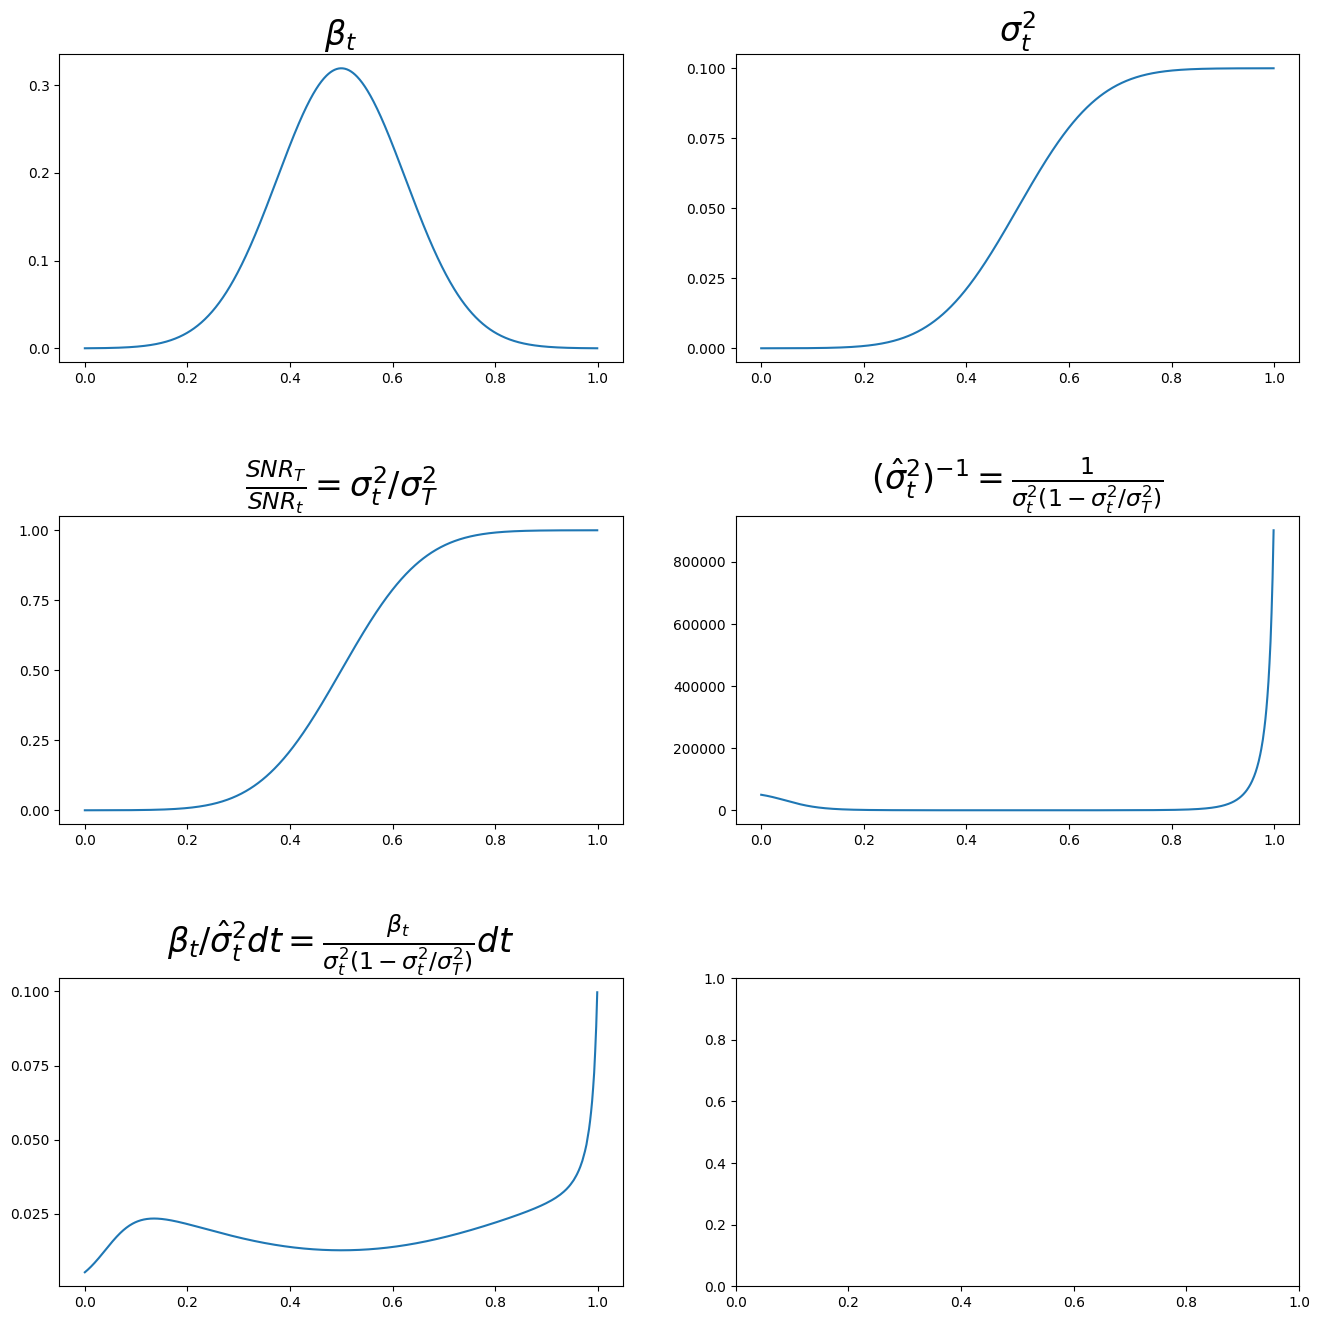

In [7]:
std_beta = 0.125
sigma_max = 0.1
sigma_min = sigma_max * 1e-4

print(std_beta, sigma_max, sigma_min)
params = SamplingParams(std_beta, sigma_max, sigma_min=sigma_min, sigma1_correction=1e-6)

num_time_steps = 1000
t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
betas = params.beta(t)
sigma_square = params.sigma_square(t)
SNRTt = params.SNR(t)

fig, axs = plt.subplots(3, 2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 20})  # Set the global font size to 12

axs = axs.flatten()

# for ax in axs:
#     ax.set_xlim(0, 4)
    
ax = axs[0]
ax.plot(t, betas)
ax.set_title(r"$\beta_t$")

ax = axs[1]
ax.plot(t, sigma_square)
ax.set_title("$\sigma_{t}^{2}$")

ax = axs[2]
ax.plot(t, SNRTt)
ax.set_title(r"$\frac{SNR_{T}}{SNR_{t}}=\sigma_t^2/\sigma_T^2$")

ax = axs[3]
ax.set_title(r"$(\hat{\sigma}_t^2)^{-1}=\frac{1}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$")
ax.plot(t, (1 / sigma_square / (1 - SNRTt)))

ax = axs[4]
ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2 dt=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)} dt$")
dt = 1 / len(betas)
ax.plot(t, (betas / sigma_square / (1 - SNRTt)) * dt)



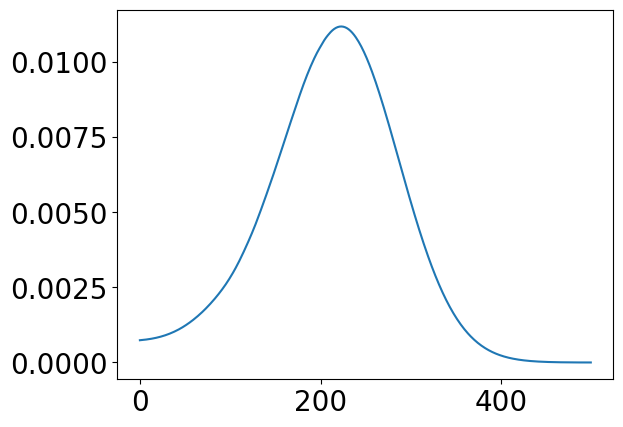

In [43]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))

idx = 0

xT = atoms_T[idx]
file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
gt_idx = int(file_name[2:])
x0 = atoms_0[gt_idx]

pos0 = torch.Tensor(x0.get_positions())
posT = torch.Tensor(xT.get_positions())

num_time_steps = 500
t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
dt = (t[1:] - t[:-1]).mean()


torch.set_printoptions(precision=6, sci_mode=False)
reverse_traj = [posT]
x = posT
v1s = []
v2s = []
v3s = []
v4s = []

verbose = False
# sampling_type = "ode"
sampling_type = "ode"
# coord_type = "Cartesian"
coord_type = "Distance"
h_coeff = 0.0


if verbose:
    print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
for idx, i in enumerate(torch.flip(t, dims=(0,))):
    if sampling_type == "hybrid":
        if idx %2 == 0:
            x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        else:
            x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)

    elif sampling_type == "ode":
        x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
    else:
        x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
    
        
    v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
    reverse_traj.append(x)
# plt.plot(v2s[::-1])
# plt.plot(v4s[::-1])
plt.plot(v1s[::-1])
# plt.plot(v3s[::-1])

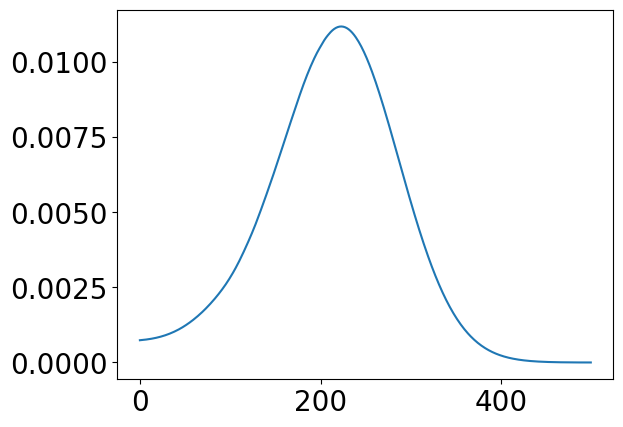

In [41]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))

idx = 0

xT = atoms_T[idx]
file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
gt_idx = int(file_name[2:])
x0 = atoms_0[gt_idx]

pos0 = torch.Tensor(x0.get_positions())
posT = torch.Tensor(xT.get_positions())

num_time_steps = 500
t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
dt = (t[1:] - t[:-1]).mean()


torch.set_printoptions(precision=6, sci_mode=False)
reverse_traj = [posT]
x = posT
v1s = []
v2s = []
v3s = []
v4s = []

verbose = False
# sampling_type = "ode"
sampling_type = "ode"
# coord_type = "Cartesian"
coord_type = "Distance"
h_coeff = 0.0


if verbose:
    print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
for idx, i in enumerate(torch.flip(t, dims=(0,))):
    if sampling_type == "hybrid":
        if idx %2 == 0:
            x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        else:
            x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)

    elif sampling_type == "ode":
        x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
    else:
        x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
    
        
    v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
    reverse_traj.append(x)
# plt.plot(v2s[::-1])
# plt.plot(v4s[::-1])
plt.plot(v1s[::-1])
# plt.plot(v3s[::-1])

In [401]:

for idx in range(100):
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]
    
    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())
    
    
    num_time_steps = 200
    t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()
    
    
    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []
    v3s = []
    v4s = []
    
    verbose = False
    sampling_type = "hybrid"
    # sampling_type = "sde"
    # coord_type = "Cartesian"
    coord_type = "Distance"
    h_coeff = 0.3
    
    
    if verbose:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
    for idx, i in enumerate(torch.flip(t, dims=(0,))):
        if sampling_type == "hybrid":
            if idx %2 == 0:
                x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
            else:
                x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
    
        elif sampling_type == "ode":
            x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        else:
            x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        
            
        v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
        reverse_traj.append(x)
    # plt.plot(v2s[::-1])
    # plt.plot(v4s[::-1])
    # plt.plot(v1s[::-1])
    # plt.plot(v3s[::-1])
    print(v1s[-1])

tensor(0.007164)
tensor(0.003398)
tensor(0.001983)
tensor(0.001625)
tensor(0.001296)
tensor(0.001890)
tensor(0.070423)
tensor(0.066871)
tensor(0.031441)
tensor(0.001773)
tensor(0.001465)
tensor(0.023833)
tensor(0.018193)
tensor(0.001810)
tensor(0.001544)
tensor(0.001565)
tensor(0.001743)
tensor(0.002278)
tensor(0.001864)
tensor(0.002457)
tensor(0.002081)
tensor(0.001860)
tensor(0.001739)
tensor(0.001462)
tensor(0.001768)
tensor(0.002316)
tensor(0.002233)
tensor(0.005920)
tensor(0.124497)
tensor(0.005974)
tensor(0.001616)
tensor(0.001954)
tensor(0.008998)
tensor(0.006431)
tensor(0.002697)
tensor(0.001914)
tensor(0.002438)
tensor(0.002065)
tensor(0.003217)
tensor(0.001996)
tensor(0.004368)
tensor(0.001776)
tensor(0.002222)
tensor(0.002514)
tensor(0.001624)
tensor(0.001862)
tensor(0.002367)
tensor(0.002261)
tensor(0.002113)
tensor(0.002311)
tensor(0.001573)
tensor(0.002605)
tensor(0.002663)
tensor(0.002773)
tensor(0.002020)
tensor(0.007963)
tensor(0.028482)
tensor(0.015243)
tensor(0.02702

In [50]:
# beta is truncated normal distribution, defined on [0, 1]

num_time_steps = 500
std_beta = 0.15  
sigma_max = 0.5 
sigma_min = sigma_max * 5e-3

beta_norm = 1 / (std_beta * np.sqrt(2 * np.pi))
scaler_beta = beta_norm * sigma_max

t = torch.linspace(0, 1, num_time_steps)
betas = torch.exp(-((t - 0.5) / std_beta) ** 2 / 2) * scaler_beta


sigma_last = 1e-5
sigma_square = betas.cumsum(dim=0) * (1 / num_time_steps) + sigma_min
sigma_square = torch.cat([torch.Tensor([sigma_min]), sigma_square])
sigma_square[-1] += sigma_last

SNRTt = sigma_square / sigma_square[-1]

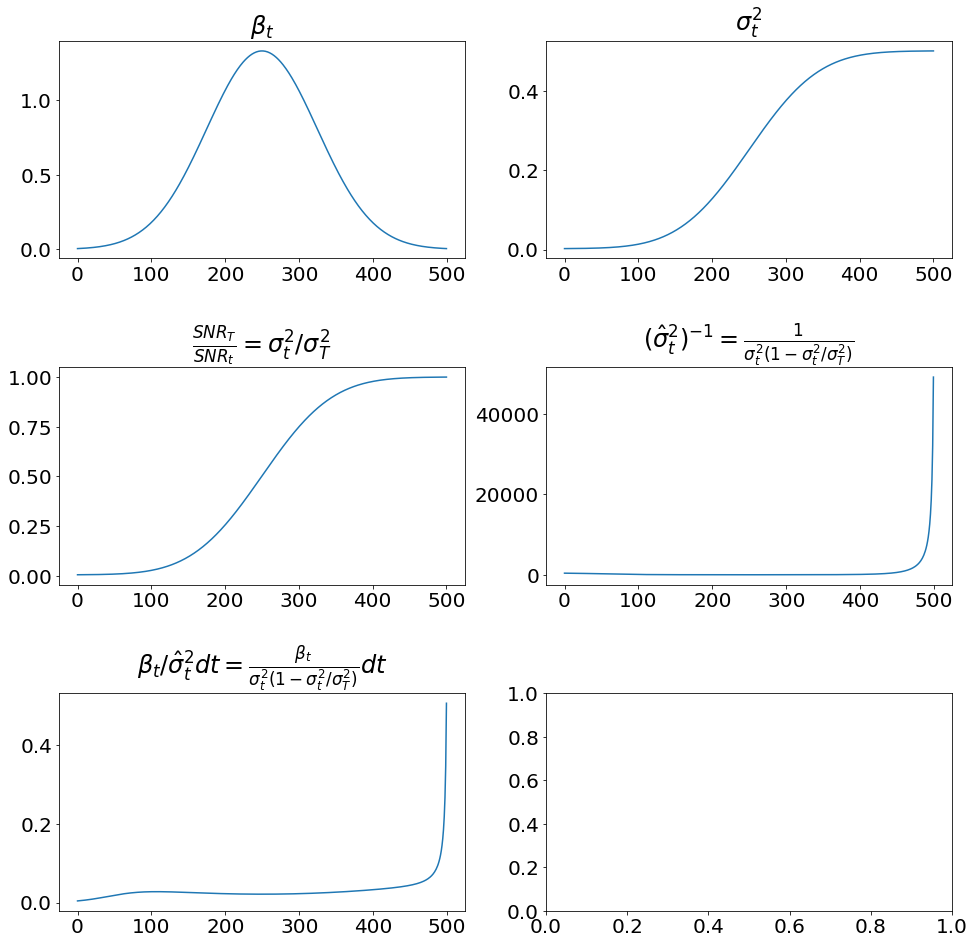

In [453]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 20})  # Set the global font size to 12

axs = axs.flatten()

# for ax in axs:
#     ax.set_xlim(0, 4)
    
ax = axs[0]
ax.plot(betas)
ax.set_title(r"$\beta_t$")

ax = axs[1]
ax.plot(sigma_square)
ax.set_title("$\sigma_{t}^{2}$")

ax = axs[2]
ax.plot(SNRTt)
ax.set_title(r"$\frac{SNR_{T}}{SNR_{t}}=\sigma_t^2/\sigma_T^2$")

ax = axs[3]
ax.set_title(r"$(\hat{\sigma}_t^2)^{-1}=\frac{1}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$")
ax.plot((1 / sigma_square[:-1] / (1 - SNRTt[:-1])))

ax = axs[4]
ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2 dt=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)} dt$")
dt = 1 / len(betas)
ax.plot((betas / sigma_square[:-1] / (1 - SNRTt[:-1])) * dt)



(Debug) mu_d - d_t	 mu_d - d_T	 mu_x - x_t	 mu_x - x_T	 score
499	0.0000		0.0000		0.0000		0.0000		0.0645
498	0.0001		0.0000		0.0001		0.0000		0.3188
497	0.0003		0.0000		0.0002		0.0000		0.8045
496	0.0008		0.0000		0.0003		0.0000		2.0255
495	0.0019		0.0000		0.0007		0.0000		3.3929
494	0.0037		0.0000		0.0013		0.0000		5.1579
493	0.0059		0.0000		0.0022		0.0000		6.5043
492	0.0078		0.0000		0.0029		0.0000		7.2267
491	0.0086		0.0001		0.0032		0.0001		7.2601
490	0.0079		0.0001		0.0029		0.0001		6.1634
489	0.0063		0.0001		0.0024		0.0001		4.6971
488	0.0043		0.0001		0.0016		0.0001		2.8795
487	0.0025		0.0001		0.0010		0.0001		1.7865
486	0.0013		0.0001		0.0005		0.0001		0.9003
485	0.0006		0.0001		0.0003		0.0001		0.3815
484	0.0002		0.0001		0.0002		0.0001		0.1949
483	0.0002		0.0001		0.0003		0.0001		0.1440
482	0.0003		0.0001		0.0003		0.0001		0.1636
481	0.0003		0.0002		0.0003		0.0001		0.1669
480	0.0003		0.0002		0.0003		0.0001		0.1784
479	0.0003		0.0002		0.0003		0.0001		0.1137
478	0.0003		0.0002		0.0003		0.0002	

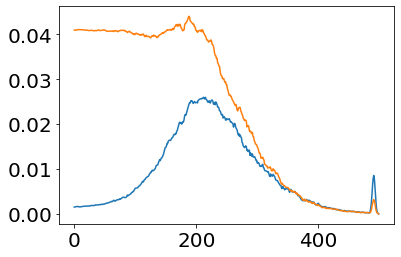

In [423]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz"))

idx = 3
xT = atoms_T[idx]
file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
gt_idx = int(file_name[2:])
x0 = atoms_0[gt_idx]

pos0 = torch.Tensor(x0.get_positions())
posT = torch.Tensor(xT.get_positions())

torch.set_printoptions(precision=6, sci_mode=False)
reverse_traj = [posT]
x = posT
v1s = []
v2s = []
v3s = []
v4s = []
for i in range(len(betas))[::-1][:]:
    x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, betas, pos0, posT, coord="Distance", h_coeff=0.0, sigma_min=1e-3, sigma_last=0)
    v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
    reverse_traj.append(x)
# plt.plot(v2s[::-1])
# plt.plot(v4s[::-1])
plt.plot(v1s[::-1])
plt.plot(v3s[::-1])

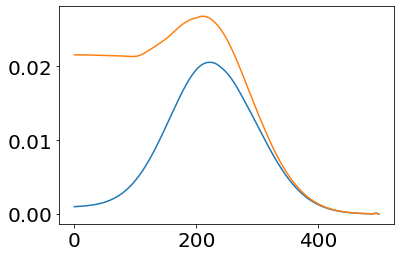

In [408]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz"))

idx = 3
xT = atoms_T[idx]
file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
gt_idx = int(file_name[2:])
x0 = atoms_0[gt_idx]

pos0 = torch.Tensor(x0.get_positions())
posT = torch.Tensor(xT.get_positions())

torch.set_printoptions(precision=6, sci_mode=False)
reverse_traj = [posT]
x = posT
v1s = []
v2s = []
v3s = []
v4s = []
for i in range(len(betas))[::-1][:]:
    x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, betas, pos0, posT, coord="Cartesian", h_coeff=0.0)
    v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
    reverse_traj.append(x)

(Debug) mu_d - d_t	 mu_d - d_T	 mu_x - x_t	 mu_x - x_T	 score
499	0.0000		0.0000		0.0000		0.0000		0.0361
498	0.0000		0.0000		0.0000		0.0000		0.0128
497	0.0000		0.0000		0.0000		0.0000		0.0135
496	0.0000		0.0000		0.0000		0.0000		0.0142
495	0.0000		0.0000		0.0000		0.0000		0.0148
494	0.0000		0.0000		0.0000		0.0000		0.0155
493	0.0000		0.0000		0.0000		0.0000		0.0161
492	0.0000		0.0001		0.0000		0.0000		0.0169
491	0.0000		0.0001		0.0000		0.0001		0.0176
490	0.0000		0.0001		0.0000		0.0001		0.0184
489	0.0000		0.0001		0.0000		0.0001		0.0192
488	0.0000		0.0001		0.0000		0.0001		0.0200
487	0.0000		0.0001		0.0000		0.0001		0.0209
486	0.0000		0.0001		0.0000		0.0001		0.0218
485	0.0000		0.0001		0.0000		0.0001		0.0227
484	0.0000		0.0001		0.0000		0.0001		0.0237
483	0.0000		0.0001		0.0000		0.0001		0.0247
482	0.0000		0.0001		0.0000		0.0001		0.0258
481	0.0001		0.0002		0.0000		0.0001		0.0269
480	0.0001		0.0002		0.0001		0.0002		0.0280
479	0.0001		0.0002		0.0001		0.0002		0.0291
478	0.0001		0.0002		0.0001		0.0002	

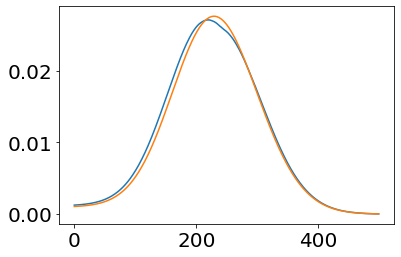

In [410]:
# plt.plot(v2s[::-1])
# plt.plot(v4s[::-1])
plt.plot(v1s[::-1])
plt.plot(v3s[::-1])

In [445]:
x0.set_positions(reverse_traj[-1])
xT.set_positions(mu_hat_list[0])
ase.build.minimize_rotation_and_translation(x0, xT)

In [449]:
abs(x0.positions - xT.positions).mean()

0.0017936878848263322

In [305]:
ase.io.write("test_gt.xyz", x0)

In [302]:
# for trj in reverse_traj:

for trj in mu_hat_list[::-1]:
    xT.set_positions(trj)
    ase.io.write("test.xyz", xT, append=True)

In [ ]:
reverse_traj = [posT]
x = posT
for i in range(len(betas))[::-1][:2]:
    print(f"\n\n!!! {i}th iteration !!!")
    x = reverse_diffusion_process(x, i, betas, pos0, posT, coord="Cartesian", h_coeff=0.0)